[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/047_cv_loc_clas/cv_loc_clas.ipynb)

## Localización + Clasificación

En el [post](https://sensioai.com/blog/046_cv_loc) anterior vimos cómo llevar a cabo la tarea de localización de un objeto en una imagen. Esta tarea consiste en predecir las coordenadas de una caja en la imagen que engloba al objeto. Si bien esta tarea nos permite saber dónde se encuentra el objeto, no nos dice de qué objeto se trata. Para ello, tenemos que combinar esta localización con una clasificación del objeto localizado.

## El dataset

Seguimos usando el mismo dataset que en el post anterior.

In [58]:
import torch
import torchvision
device = "cpu"
device

'cpu'

In [59]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar


5717

In [60]:
classes = ["background",
            "aeroplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "diningtable",
            "dog",
            "horse",
            "motorbike",
            "person",
            "pottedplant",
            "sheep",
            "sofa",
            "train",
            "tvmonitor"]

También usaremos las mismas funciones de ayuda para generar las anotaciones, visualizar imágenes, normalizar las cajas, etc.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [62]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

Y de la misma manera, para poder entender bien lo que estamos haciendo, vamos a trabajar con única imagen.

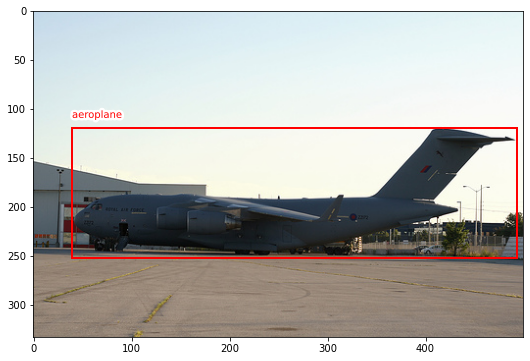

In [63]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [64]:
anns

(array([1]), array([[ 39, 119, 454, 133]]))

## El Modelo

A diferencia de en el caso de la localización, ahora vamos a intentar predecir tanto la caja como la clase. Para ello vamos a combinar la tarea de clasificación (en la que tenemos a la salida un número de neuronas igual al número de clases, y el resultado es una distribución de probabilidad) con la localización (en la que tenemos 4 neuronas en la salida que representan las coordenadas de la caja).

In [65]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class Model(torch.nn.Module):
  def __init__(self, n_classes, n_channels=3):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.fc1 = block2(64*6*6, 100)
    self.fc2_loc = torch.nn.Linear(100, 4)
    self.fc2_cls = torch.nn.Linear(100, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x_loc = self.fc2_loc(x)
    x_cls = self.fc2_cls(x)
    return x_loc, x_cls

In [66]:
model = Model(n_classes = len(classes))
output_loc, output_cls = model(torch.randn(64, 3, 100, 100))
output_loc.shape, output_cls.shape

(torch.Size([64, 4]), torch.Size([64, 21]))

Nuestro modelo está formado por una `backbone`, la CNN, que se encarga de extraer las características de las imágenes necesarias para llevar a cabo diferentes tareas. La salida de esta `backbone` alimenta dos `heads`, o cabezas, diferentes, cada una de las cuales lleva a cabo una tarea diferente. Este tipo de arquitecturas es muy común en el campo de la visión artificial, en el que podemos tener múltiples `heads` llevando a cabo distintas tareas sobre una misma `backbone` (clasificación, localización, detección, segmentación, etc).  Así es como funcionan, por ejemplo, las redes neuronales en los coches Tesla para conducción autónoma. Varias `backbones` extraen características de las imágenes de las diferentes cámaras del coche y decenas de `heads` combinan esta información para dar predicciones tales como localización de señales de tráfico, detección de vehículos, detección de líneas en la carretera, etc.

![](https://gradientdescent.co/uploads/default/original/1X/789dfc63fcad7baa1cb9ece3dc4cbfc0b3f8f691.jpeg)

## Fit de una imagen

La clave a la hora de entrenar la arquitectura anterior consiste en utilizar la función de pérdida adecuada para cada `head`. En el caso de la localización, usaremos la función `L1` ya que hacemos `regresión` (en el post anterior ya mencionamos que funciona mejor que `MSE`). En cuanto a la cabeza de clasificación, usaremos la `CrossEntropy` que ya conocemos de posts anteriores.

In [67]:
import albumentations as A

# with coco format the bb is expected in 
# [x_min, y_min, width, height] 
def get_aug(aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['labels']})

trans = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs, labels

((100, 100, 3), [(7.8, 35.73573573573574, 90.8, 39.93993993993994)], [1])

In [68]:
bb, label = bbs[0], labels[0]
bb, label

((7.8, 35.73573573573574, 90.8, 39.93993993993994), 1)

In [69]:
bb_norm = norm(bb, img.shape[:2])
bb_norm

array([0.078     , 0.35735736, 0.908     , 0.3993994 ])

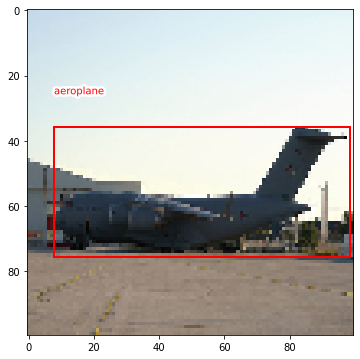

In [70]:
plot_anns(img, (labels, bbs))
plt.show()

In [71]:
def fit(model, X, y1, y2, epochs=1, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_loc = torch.nn.L1Loss()
    criterion_cls = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
        optimizer.zero_grad()
        y_hat1, y_hat2 = model(X)
        loss_loc = criterion_loc(y_hat1, y1)
        loss_cls = criterion_cls(y_hat2, y2)
        loss = loss_loc + loss_cls
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss_loc.item())
        train_loss_cls.append(loss_cls.item())
        print(f"Epoch {epoch}/{epochs} loss_loc {np.mean(train_loss_loc):.5f} loss_cls {np.mean(train_loss_cls):.5f}")

In [72]:
model = Model(n_classes = len(classes))
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0)
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0)
label_tensor = torch.tensor(label).long().unsqueeze(0)
fit(model, img_tensor, bb_tensor, label_tensor, epochs=30)

Epoch 1/30 loss_loc 0.42393 loss_cls 3.05736
Epoch 2/30 loss_loc 0.40484 loss_cls 2.96519
Epoch 3/30 loss_loc 0.39728 loss_cls 2.85662
Epoch 4/30 loss_loc 0.39359 loss_cls 2.67846
Epoch 5/30 loss_loc 0.37882 loss_cls 2.39170
Epoch 6/30 loss_loc 0.34315 loss_cls 1.95176
Epoch 7/30 loss_loc 0.30413 loss_cls 1.34154
Epoch 8/30 loss_loc 0.36393 loss_cls 0.63428
Epoch 9/30 loss_loc 0.41716 loss_cls 0.14527
Epoch 10/30 loss_loc 0.35131 loss_cls 0.01680
Epoch 11/30 loss_loc 0.42009 loss_cls 0.00154
Epoch 12/30 loss_loc 0.43489 loss_cls 0.00022
Epoch 13/30 loss_loc 0.34731 loss_cls 0.00005
Epoch 14/30 loss_loc 0.26417 loss_cls 0.00002
Epoch 15/30 loss_loc 0.22537 loss_cls 0.00001
Epoch 16/30 loss_loc 0.37533 loss_cls 0.00000
Epoch 17/30 loss_loc 0.43748 loss_cls 0.00000
Epoch 18/30 loss_loc 0.40977 loss_cls 0.00000
Epoch 19/30 loss_loc 0.24842 loss_cls 0.00000
Epoch 20/30 loss_loc 0.21024 loss_cls 0.00000
Epoch 21/30 loss_loc 0.21219 loss_cls 0.00000
Epoch 22/30 loss_loc 0.28038 loss_cls 0.000

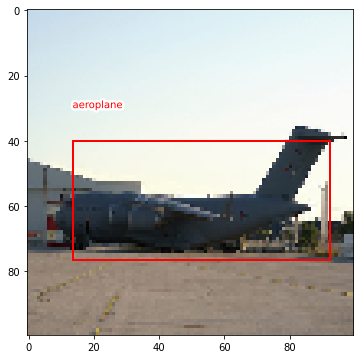

In [76]:
model.eval()
pred_bb_norm, pred_cls = model(img_tensor.to(device))
pred_bb = unnorm(pred_bb_norm[0].detach().numpy(), img.shape[:2])
pred_cls = torch.argmax(pred_cls, axis=1)[0]
plot_anns(img, ([pred_cls], [pred_bb]))
plt.show()

En este punto, ¿Te ves capaz de entrenar un modelo de localización + clasificación para éste dataset? Podrías intentar filtrarlo para quedarte con aquellas muestras que sólo tengan una caja y después implementar un bucle de entrenamiento completo con validación (tienes ejemplos en los posts anteriores). Al tratarse de imágenes naturales, también puedes utilizar una red pre-entrenada y hacer [transfer learning](https://sensioai.com/blog/044_cnn_transfer_learning) (en este caso recuerda hacer el *resize* al mismo tamaño que el de la red original).

## Resumen

En este post hemos visto cómo podemos entrenar una `red neuronal` para la tarea de localización + clasificación de un objeto en una imagen. Esta tarea consiste en predecir una caja alrededor del objeto y, además, decir de qué objeto se trata. Para ello hemos implementado una red neuronal convolucional con dos cabezas, un responsable de la localización y otra de la clasificación. Cada cabeza es entrenada con su función de pérdida correspondiente. Este patrón de diseño es muy común en el campo de la visión artificial, en la que una CNN se encarga de extraer características de una imagen mientras que diferentes cabezas se encargan de dar las salidas para las distintas tareas.